# Practical Session: Probabilistic Numerics for ODEs
Author: [Nathanael Bosch](https://nathanaelbosch.github.io)


## **Overview**

In this tutorial you will **implement your own ODE filter, completely from scratch!** 
The tutorial is structured as follows:

0. [**The ODE**](#problem-setting)  
   The guiding example for this tutorial will be an epidemeological dynamical system: a so-called SIRD model.
   It is a simple model that describes how a disease evolves over time in a population.
1. [**Solve an ODE with forward Euler**](#forward-euler)  
   The "hello world" of solving ODEs. 
   Forward Euler is a very simple, non-probabilistic ODE solver. 
   We will use it to perform first simulations of the SIRD model, and we will visualize the solution and the numerical errors - _which are not quantified by the algorithm_.
2. _Towards ODE filters:_ [**Gauss-Markov priors and Gaussian inference**](#prior)  
   ODE filters essentially perform nonlinear Gauss-Markov regression.
   So, in this next step we explore these Gauss-Markov priors and get more familiar with Gaussian distributions.
   We  
   &nbsp; &nbsp; + [sample from a Gauss--Markov prior](#sampling)  
   &nbsp; &nbsp; + implement Gaussian [marginalization](#marginalization) and [conditioning](#affine-conditioning)  
   &nbsp; &nbsp; + condition on non-linear observations by [linearizing](#linearization) the model  
   These are the main algorithmic building blocks that we need for _extended Kalman filtering_; next, we turn it into an _ODE filter_.
3. [**The ODE information operator**](#information-operator)  
   In this section we define they key component of the ODE filter: the _information operator_.
   This is the part that turns an extended Kalman filter into an ODE solver! 
4. Putting things together: [**Your first ODE filter**](#ode-filtering)  
   We assemble all of the above to build an ODE filter, and we use it to solve the SIRD model.
   We will visualize the posterior and its uncertainties, and again look at the numerical error - _and this time also at error estimates_! 
5. [**Calibrating uncertainties**](#calibration)  
   It turns out that there is still one thing left to do: We need to calibrate the error estimates.
   So, we implement a quasi-maximum likelihood estimation for the one free _diffusion_ hyperparameter, and get a _calibrated_ ODE filter.
   We solve the ODE again, visualize it, and get meaningful posteriors!

**At this point you will have implemented your own ODE filter, completely from scratch!**  
There is one more section where we use these filters, not to solve an ODE but inside of an inference problem:   

6. [**Parameter inference**](#parameter-inference)  
   Sometimes you don't want to infer the solution from the ODE, but infer the ODE itself from some data. This is what we'll consider in this _parameter inference_ part.
   We will use our ODE filter implementation to do some maximum-likelihood estimation of the SIRD parameters (the contact rate, recovery rate, and death rate).


After all of this, if you still have time and are curious for more, there are two directions you could go:
there is still quite some functionality that one would want to have when using ODE filters, so you could have a look at [this list](#more) and explore these.
Or you could simply check out our [software packages](#software)! They provide feature-rich ODE filters which are implemented very efficiently, and there are many tutorials to guide you through both basic and more avanced use-cases.

So without further ado, **let's get started!**

# Preliminaries

Make sure you installed all the required packages (see the [requirements.txt](https://github.com/probabilistic-numerics/probnum-spring-school/blob/main/2023_tutorials/requirements.txt)).
If not, the following should have you covered:
```bash
pip3 install --upgrade pip
pip3 install numpy matplotlib scipy ipympl
pip3 install --upgrade "jax[cpu]"
```
Note that [`jax`](https://github.com/google/jax) can be a bit tricky to install, so in doubt please follow the instructions on [their github page](https://github.com/google/jax#installation).  
*Side note:* Always use a [virtual environment](https://docs.python.org/3/tutorial/venv.html)! (or something like [conda](https://docs.conda.io/en/latest/)). 

The following cell should then run without errors:

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

from typing import Callable, Tuple
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
import jax
import jax.numpy as jnp

FIGSIZE = (8, 4)
plt.rcParams['figure.figsize'] = FIGSIZE
plt.rcParams["figure.autolayout"] = True

# 0. Problem Setting: Ordinary Differential Equations (ODEs)  <a class="anchor" id="problem-setting">  </a>

_In general_, we are interested to solve ODEs of the form
$$
\dot{y}(t) = f(y(t), t), \quad t \in [t_0, t_\text{max}], \qquad y(t_0) = y_0,
$$
where $f: \mathbb{R}^n \times [t_0, t_\text{max}] \to \mathbb{R}^n$ is the vector field, $[t_0, t_\text{max}]$ is the time interval, and $y_0 \in \mathbb{R}^n$ is the initial condition.  
**Our goal is to find $y : [t_0, t_\text{max}] \to \mathbb{R}^n$ which satisfies the ODE and the initial condition. This is what we call the _solution_ of the ODE.**

### The concrete ODE: An epidemeological dynamical system  <a class="anchor" id="sird">  </a>

The concrete dynamical system that we will consider in this tutorial is an epidemeological [SIRD model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIRD_model), the _Susceptibe-Infectious-Recovered-Deceased model_, which describes the evolution of an infectious disease in a population.
It partitions the population into a discrete set of compartments and describes the transitions between these compartments with a set of ordinary differential equations:

$$\begin{aligned}
\frac{dS(t)}{dt} &= -\beta S(t) I(t) \\
\frac{dI(t)}{dt} &= \beta S(t) I(t) - \gamma I(t) - \eta I(t) \\
\frac{dR(t)}{dt} &= \gamma I(t) \\
\frac{dD(t)}{dt} &= \eta I(t)
\end{aligned}$$

where $S$, $I$, $R$, and $D$ are the fractions of the population that are susceptible, infected, recovered, and deceased, respectively, 
and $\beta$, $\gamma$, and $\eta$ are the infection, recovery, and death rates, respectively.
In this example, we consider initial conditions $S_0 = 0.99$, $I_0 = 0.01$, $R_0 = 0$, and $D_0 = 0$, parameters $\beta = 0.5$, $\gamma = 0.06$, and $\eta = 0.002$, and a time interval $[t_0, t_\text{max}] = [0, 100]$.


Here is this SIRD problem in code:

In [2]:
tspan = (0.0, 100.0)
y0 = np.array([0.99, 0.01, 0.0, 0.0])
p = (beta, gamma, eta) = (0.5, 0.06, 0.002)

def f(y, t, p):
    S, I, R, D = y
    beta, gamma, eta = p
    return jnp.array([ 
        -beta * S * I,
        beta * S * I - gamma * I - eta * I,
        gamma * I,
        eta * I,
    ])

labels = ["S(t)", "I(t)", "R(t)", "D(t)"] # used later for plotting

# 1. Solve the ODE with forward Euler  <a class="anchor" id="forward-euler">  </a>

To warm up and get more familiar with ODEs, let's first solve the ODE with a simple ODE solver, namely [forward Euler](https://en.wikipedia.org/wiki/Euler_method).
It works as follows:
1. Decide on a discrete time grid $t_0, t_1, \dots, t_K$. Typically: $t_k = t_0 + k \Delta t$ for some time step $\Delta t > 0$.
2. Initialize the solution $y(t_0)=y_0$.
3. Iteratively compute the solution at the next time step $y(t_{k+1})$ from the solution at the current time step $y(t_k)$:
   $$
   y(t_{k+1}) = y(t_k) + \Delta t_k f(y(t_k), t_k).
   $$

<div class="alert alert-block alert-info">
    
**Task:** Implement forward Euler in the function `forward_euler` below.

</div>

In [5]:
def forward_euler(f: Callable, y0: np.ndarray, ts: np.ndarray, p=p) -> np.ndarray:
    ys = np.zeros((len(ts), len(y0)))

    # TODO
    ys[0] = y0
    for i,t in enumerate(ts):
        if i == 0: continue
        delta_t = ts[i] - ts[i-1]
        ys[i] = ys[i-1] + delta_t * f(ys[i-1],ts[i-1],p)

    return ys

Let's try it out!

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


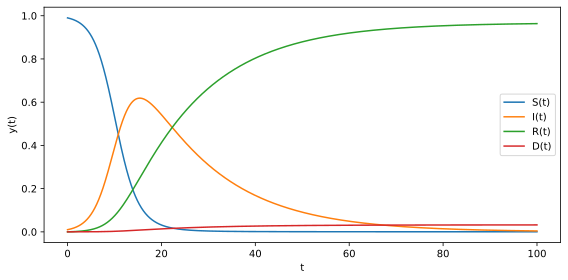

In [6]:
dt_small = 0.01 
times = np.arange(tspan[0], tspan[1], dt_small) 
ys = forward_euler(f, y0, times)

# Plot the result:
fig, ax = plt.subplots()
ax.plot(times, ys, label=labels)
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend()

Looks good! But we also took very small steps here. What about coarser steps? Or _much_ coarser steps?

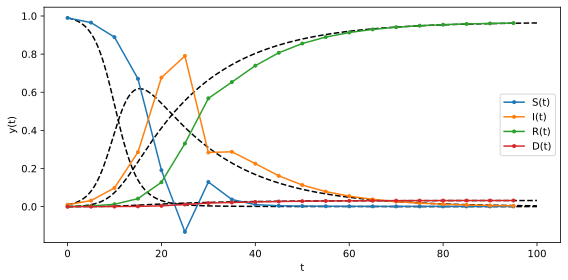

In [10]:
# TODO
dt_coarse = 5
times_coarse = np.arange(tspan[0], tspan[1], dt_coarse) 
ys_coarse = forward_euler(f, y0, times_coarse)

# Plot the result:
fig, ax = plt.subplots()
ax.plot(times, ys, color="black", linestyle="--")
ax.plot(times_coarse, ys_coarse, label=labels, marker="o", markersize=3)
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend()

We can definitely see the error now. Note that the black dashed "accurate" solution also has error of course: it too has been computed by a numerical algorithm. 
For this notebook, we consider that error to be "small enough" so that we can compare the coarser versions to it.

Let's directly plot the errors to get an even clearer picture:

Make sure that this here is an integer: 500.0


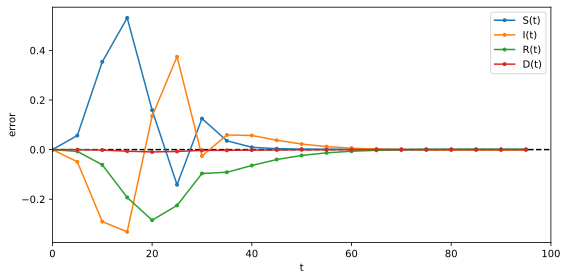

In [11]:
# For the plot to work, make sure that dt_coarse is a multiple of dt_small
print(f"Make sure that this here is an integer: {dt_coarse / dt_small}")
stride = int(dt_coarse / dt_small)
errors = ys_coarse - ys[::stride]

fig, ax = plt.subplots()
ax.axhline(0, color="black", linestyle="--")
ax.plot(times_coarse, errors, label=labels, marker="o", markersize=3)
ax.set_xlabel("t")
ax.set_ylabel("error")
ax.set_xlim(*tspan)
ax.legend()

There we have it: _there are errors, but they are not quantified by the algorithm!_ Which is unsurprising of course, it's forward Euler after all.

So, let's do better and quantify numerical error. **Let's do _Probabilistic Numerics_!**

# 2. Towards Probabilistic Numerical ODE Solvers  <a class="anchor" id="pn">  </a>

Let's forget most of the above and start over. 
We want to find the ODE solution $y : [t_0, t_\text{max}] \to \mathbb{R}^n$ which satisfies the ODE $y'(t) = f(y(t), t)$ and the initial condition $y(t_0) = y_0$.
But we also know that, even though there is a unique function $y$ with this property, we can never compute it exactly; we can only compute it _approximately_.
So, let's instead find a _probability distribution_ over the ODE solution:
$$
p \left( y(t) \mid y(0) = y_0, \{ y'(t_i) = f(y(t_i), t_i) \}_{i=1}^N \right),
$$
where $t_0, t_1, \dots, t_N$ is a discrete time grid. 

As you probably know from the lectures, we consider this to be a [Bayesian state estimation problem](https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation), which can be solved (approximately) with [extended Kalman filtering](https://en.wikipedia.org/wiki/Extended_Kalman_filter).
The result is a _probabilistic numerical ODE solution_, and we call the algorithm an _ODE filter_.

**Let's build an ODE filter, step by step!**

## 2.1. The Gauss--Markov Prior: 2-times integrated Wiener processes <a class="anchor" id="prior"> </a>

To do Bayesian inference, we need a prior distribution $p(y(t))$ over the ODE solution $y(t)$.
A natural and common choice are $q$-times integrated Wiener processes (with $q \geq 1$), which are Gauss-Markov processes with transition densities of the form
$$
p( Y(t+h) \mid Y(t) ) = \mathcal{N} \left( Y(t + h); Y(t) A(h), Q(h) \right),
$$
where $A(h)$ and $Q(h)$ are known matrices that depend on the time step $h$ (they will be given in code below).
The capital $Y(t)$ is a state vector of dimension $d \cdot (q+1)$ (where $d$ is the dimension of the ODE) which tracks not just the ODE solution $y(t)$, but also its first $q$ derivatives:
$$
Y(t) = \begin{bmatrix} y(t) \\ y'(t) \\ \vdots \\ y^{(q)}(t) \end{bmatrix}.
$$
We can access them via projection matrices $E_0, E_1, \dots, E_q$: $E_i Y(t) = y^{(i)}(t)$.

In code, these are the transition martices of the one-dimensional two-times integrated Wiener process prior:

In [12]:
q = 2
def A1(h: float):
    return np.array([[1, h, h**2 / 2], [0, 1, h], [0, 0, 1]])

sigma_sq = 1e-1 # ignore this hyperparemeter for now; it will be discussed later!
def Q1(h: float, sigma_sq=sigma_sq):
    return sigma_sq * np.array(
    [[h**5 / 20, h**4 / 8, h**3 / 6],
     [h**4 / 8, h**3 / 3, h**2 / 2],
     [h**3 / 6, h**2 / 2, h]]
)

A1(0.1), Q1(0.1)

(array([[1.   , 0.1  , 0.005],
        [0.   , 1.   , 0.1  ],
        [0.   , 0.   , 1.   ]]),
 array([[5.00000000e-08, 1.25000000e-06, 1.66666667e-05],
        [1.25000000e-06, 3.33333333e-05, 5.00000000e-04],
        [1.66666667e-05, 5.00000000e-04, 1.00000000e-02]]))

Since the ODE is $d$-dimensional we also need a $d$-dimensional prior. We can simply use the same prior for each dimension, and then stack them together:

In [13]:
d = len(y0)
A = lambda h: np.kron(A1(h), np.eye(d))
Q = lambda h, sigma_sq=sigma_sq: np.kron(Q1(h, sigma_sq), np.eye(d))

Let's also implement the projection matrices $E_0, E_1, E_2$:

In [14]:
# Accessing the i-th derivative with E_i
E0 = np.kron(np.array([[1, 0, 0]]), np.eye(d))
E1 = np.kron(np.array([[0, 1, 0]]), np.eye(d))
E2 = np.kron(np.array([[0, 0, 1]]), np.eye(d))
E0, E1, E2

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

We also have a standard Gaussian initial distribution $$p(Y(t_0)) = \mathcal{N}(Y(t_0); m_0, C_0),$$ and we assume $m_0 = 0$ and $C_0 = I$.

*Note:* This initial distribution does not relate to the initial condition $y(t_0) = y_0$ of the ODE! It is just a prior. We will condition on the ODE initial condition later.

In [15]:
# Initial mean and covariance
m0 = np.zeros(d * (q + 1))
C0 = np.eye(d * (q + 1))

## 2.2. Visualize the prior: Sampling <a class="anchor" id="sampling"></a>

To get a feeling for the prior $Y(t)$, let's sample from it and plot the samples.
Recall: The prior is given by
$$\begin{aligned}
p(Y(t_0)) &= \mathcal{N}(Y(t_0); m_0, C_0) \\
p(Y(t+h) \mid Y(t)) &= \mathcal{N} \left( Y(t + h); A(h)Y(t), Q(h) \right),
\end{aligned}$$
with $m_0, C_0, A(h), Q(h)$ as given above.

<div class="alert alert-block alert-info">
    <b>Task:</b> Implement the sampling function <code>sample_prior</code> below.
</div>

In [27]:
def sample_prior(
    m0: np.ndarray, 
    C0: np.ndarray, 
    ts: np.ndarray,
    A: Callable[[float], np.ndarray], 
    Q: Callable[[float], np.ndarray]
) -> np.ndarray:
    sample = np.zeros((len(ts), d*(q+1)))
    
    # TODO
    p0 = np.random.multivariate_normal(m0,C0)
    for i in range(1,len(ts)):
        h = ts[i] - ts[i-1]
        sample[i] = np.random.multivariate_normal(A(h) @ sample[i-1],Q(h))
    

    
    return sample

Here is some helper code to plot the sample

In [28]:
def plot_sample(ts, sample, axes=None, derivative=0):
    if axes is None:
        _, axes = plt.subplots(d, figsize=(FIGSIZE[0], FIGSIZE[1]/3*d), sharex=True)

    E = (E0, E1, E2)[derivative]
    Yi = sample @ E.T
    
    for j in range(d):
        axes[j].plot(ts, Yi[:, j], color=f"C{j}")
        ddt = "" if derivative == 0 else f"$\\frac{{d^{derivative}}}{{dt^{derivative}}}$ "
        axes[j].set_ylabel(f"{ddt}{labels[j]}")
        axes[j].set_xlim(ts[0], ts[-1])
    
    axes[-1].set_xlabel("t")

    fig = axes[0].get_figure()
    return fig, axes

Let's sample and plot the result:

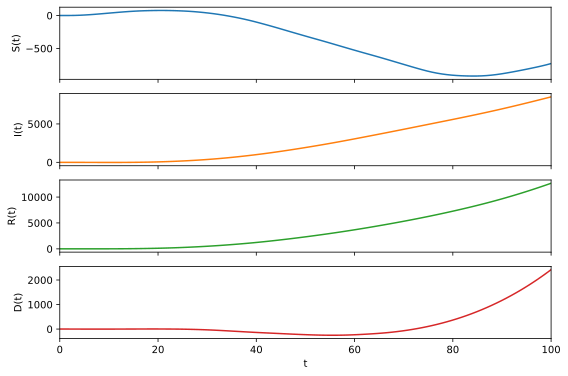

In [29]:
ts = np.linspace(tspan[0], tspan[1], 100)
Ys = sample_prior(m0, C0, ts, A, Q)

fig, axes = plot_sample(ts, Ys)

Neat! To get a better feeling for the prior _distribution_, let's plot many samples:

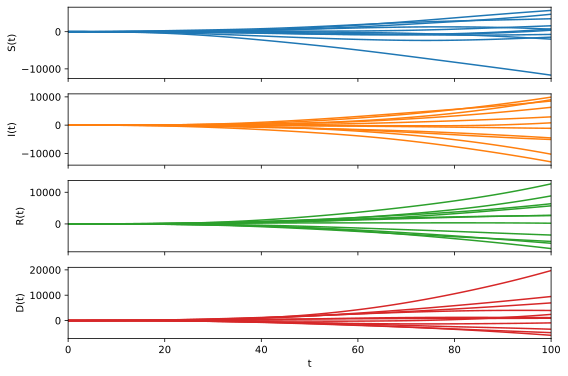

In [30]:
ts = np.linspace(tspan[0], tspan[1], 100)
fig, axes = plot_sample(ts, Ys)
for _ in range(10):
    Ys = sample_prior(m0, C0, ts, A, Q)
    plot_sample(ts, Ys, axes=axes)

**This is what the 2-times integrated Wiener process prior looks like!**

Here we show the zeroth derivative of the state vector $Y(t)$, so the prior for the ODE solution $y(t)$.
The lines look quite different from the ODE solution that we're looking for; but after all it's just a prior. 
We will relate the prior to the ODE solution later.

To really see why it's called a "2-times integrated Wiener process" we can plot the second derivative of the sample (by setting `derivative=2` in the `plot_sample` call):

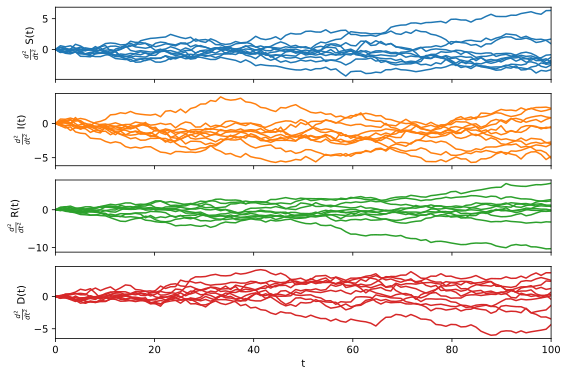

In [31]:
# plot the second derivative; it should look like a Wiener process (a random walk)
ts = np.linspace(tspan[0], tspan[1], 100)
fig, axes = plot_sample(ts, Ys, derivative=2)
for _ in range(10):
    Ys = sample_prior(m0, C0, ts, A, Q)
    plot_sample(ts, Ys, axes=axes, derivative=2)

## 2.3. Towards inference: Marginalizing and conditioning Gaussians <a class="anchor" id="towards-filter"></a>

We have a prior $p(Y(t))$. But we want a posterior $p(Y(t) \mid \text{data})$. 
To get there, we need to _marginalize_ and _condition_ Gaussians.

### Gaussian marginalization <a class="anchor" id="marginalization"></a>

Let $x$ be a Gaussian-distributed random variable with 
$p(x) = \mathcal{N}(x; m, P)$, 
and let $y$ be conditionally Gaussian-distributed given $x$, with
$p(y \mid x) = \mathcal{N}(y; A x + b, C)$.  
Then $y$ is also Gaussian-distributed:
$$
p(y) = \mathcal{N}(y; A m + b, A P A^\top + C).
$$

<font color='gray'><i>FilteringFunFact: In Kalman filtering, this is also known as the "predict" step.</i></font> 

<div class="alert alert-block alert-info">
    <b>Task:</b> Implement this in the function <code>marginalize_gaussian</code> below.
</div>

In [40]:
def marginalize_gaussian(
    m: np.ndarray, 
    P: np.ndarray, 
    A: np.ndarray, 
    B: np.ndarray,
    C: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    
    # note: B is only added for generality to match the math, but is ignored in the prior
    
    # TO IMPLEMENT
    mnew = A @ m + B
    Pnew = A @ P @ A.T + C
    
    # note here is where we could use square root decomp
    
    return mnew, Pnew

Let's iteratively apply this to the prior to compute Gaussian marginals $p(Y(t_i)) = \mathcal{N}(Y(t_i); m_i, P_i)$ for all $i$.

<font color='gray'><i>FilteringFunFact: This is basically a Kalman filter without any data.</i></font> 

<div class="alert alert-block alert-info">
    <b>Task:</b> Implement this in the function <code>compute_marginals</code> below.
</div>

In [41]:
def compute_marginals(
    m0: np.ndarray, 
    C0: np.ndarray, 
    ts: np.ndarray, 
    A: Callable[[float], np.ndarray], 
    Q: Callable[[float], np.ndarray]
) -> Tuple[np.ndarray, np.ndarray]:
    ms = np.zeros((len(ts), d * (q + 1)))
    Cs = np.zeros((len(ts), d * (q + 1), d * (q + 1)))
    
    # TO IMPLEMENT
    ms[0] = m0
    Cs[0] = C0
    for i in range(1,len(ts)):
        h = ts[i] - ts[i-1]
        ms[i], Cs[i] = marginalize_gaussian(ms[i-1],Cs[i-1],A(h),0,Q(h))
    
    
    return ms, Cs

ts = np.linspace(tspan[0], tspan[1], 100)
ms, Cs = compute_marginals(m0, C0, ts, A, Q)

Here is some helper code to plot the marginals:

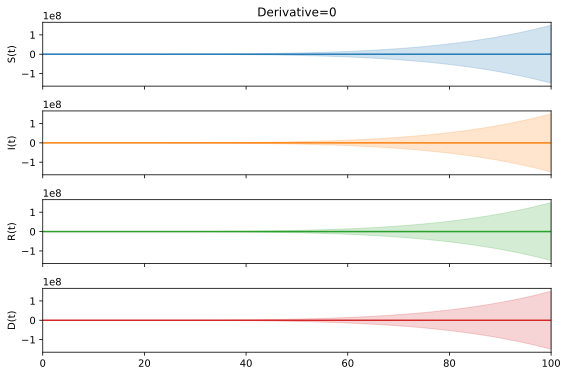

In [42]:
def plot_marginals(ts, ms, Cs, derivative=0):
    fig, axes = plt.subplots(d, figsize=(FIGSIZE[0], FIGSIZE[1]/3*d), sharex=True)
    E = (E0, E1, E2)[derivative]
    mi = ms @ E.T
    Ci = np.matmul(np.matmul(E, Cs), E.T)
    for j in range(d):
        axes[j].plot(ts, mi[:, j], color=f"C{j}")
        axes[j].fill_between(
            ts,
            mi[:, j] - 2 * Ci[:, j, j],
            mi[:, j] + 2 * Ci[:, j, j],
            alpha=0.2,
            color=f"C{j}",
        )        
        axes[j].set_xlim(ts[0], ts[-1])
        axes[j].set_ylabel(labels[j])
    axes[0].set_title(f"Derivative={derivative}")
    return fig, axes


fig, ax = plot_marginals(ts, ms, Cs)

<div class="alert alert-block alert-success">
    <b>Check:</b> Zero-mean, ever-increasing variance, and a y-axis in the order of 1e8?
    If yes then your marginalization code is probably correct!
</div>

So now that we know how to interact with the prior, we will work towards _informing_ the prior about the ODE data.
This is done by _conditioning_ the prior.

### Affine Gaussian Conditioning <a class="anchor" id="affine-conditioning"></a>

Let $x$ be a Gaussian-distributed random variable with
$p(x) = \mathcal{N}(x; m^-, P^-)$,
and let $y$ be conditionally Gaussian-distributed given $x$, with
$p(y \mid x) = \mathcal{N}(y; A x + b, C)$.
Then, $x$ is also conditionally Gaussian-distributed given $y$:
$$
\begin{aligned}
p(x \mid y) &= \mathcal{N}(x; m, P) \\
m &= m^- + P^- A^\top (A P^- A^\top + C)^{-1} (y - A m^- - b) \\
P &= P^- - P^- A^\top (A P^- A^\top + C)^{-1} A P^-.
\end{aligned}
$$

<font color='gray'><i>FilteringFunFact: This is also known as the "update" step in Kalman filtering.</i></font> 

<div class="alert alert-block alert-info">
    <b>Task:</b> Implement this in the function <code>condition_gaussian</code> below.
</div>

In [44]:
def condition_gaussian(
    m: np.ndarray, 
    P: np.ndarray, 
    A: np.ndarray, 
    b: np.ndarray, 
    C: np.ndarray, 
    y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
   

    yhat = A @ m + b
    S = A @ P @ A.T + C
    # yhat, S = marginalize_gaussian(m,P,A,b,C)
    # TO IMPLEMENT
    K = P @ A.T @ np.linalg.inv(S)
    mnew = m + K @ (y-yhat)
    Pnew = P - K @ A @ P
    

    return mnew, Pnew

Let's try it out! 

<div class="alert alert-block alert-info">
    <b>Task:</b> Update the initial distribution $p(Y(t_0))$ on the initial condition: $y(t_0) = y_0$.
</div>

<font color='gray'><i>Hint:</i>
Recall that $E_0 Y(t) = y(t)$.  
</font> 
<font color='gray'><i>Hint 2:</i>
Conditioning on an equation is equivalent to conditioning on a Dirac observation, which again is equivalent to conditioning on a Gaussian observation with zero variance (i.e. $C = 0$).
</font> 

In [45]:
m, C = condition_gaussian(m0,C0,E0,0,0,y0) # TODO
m, C

(array([0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

After doing this, we should now satisfy the initial condition exactly: $\mathbb{E}[E_0 Y(t_0)] = y_0$ and $\mathbb{V}[E_0 Y(t_0)] = 0$!  

<div class="alert alert-block alert-info">
    <b>Task:</b> Check that this holds: $\mathbb{E}[E_0 Y(t_0)] = y_0$ and $\mathbb{V}[E_0 Y(t_0)] = 0$
</div>

In [49]:
# TODO
E0 @ m == y0
E0 @ C @ E0.T

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Let's look how this affects the prior marginals:

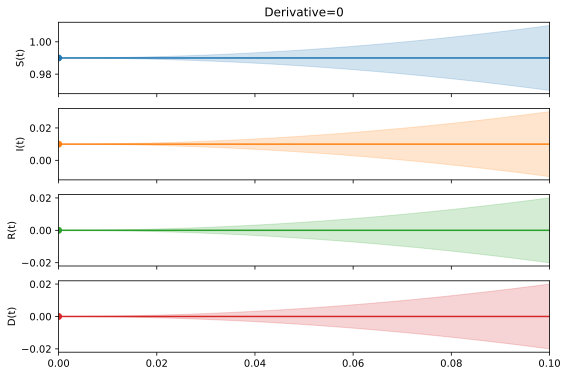

In [50]:
ts = np.linspace(0, 0.1, 100)
ms, Cs = compute_marginals(m, C, ts, A, Q)
fig, axes = plot_marginals(ts, ms, Cs)
# also plot the initial value:
for i in range(d):
    axes[i].scatter(0, y0[i], color=f"C{i}", marker="o")

<div class="alert alert-block alert-success">
    <b>Check:</b> The mean should still be constant, but not zero, and the variance should still increase over time.
    In particular, the initial condition should now be satisfied!
</div>

From the ODE problem we also get derivative information at the initial time $t_0$: 
$\dot{y}(t_0) = f(y_0, t_0)$. 
This is also useful information, so let's condition on this, too!

<div class="alert alert-block alert-info">
    <b>Task:</b> Condition on the initial derivative: $\dot{y}(t_0) = f(y_0, t_0)$.
</div>

<font color='gray'><i>Hint:</i>
Recall that $E_1 Y(t) = \dot{y}(t)$.
</font>

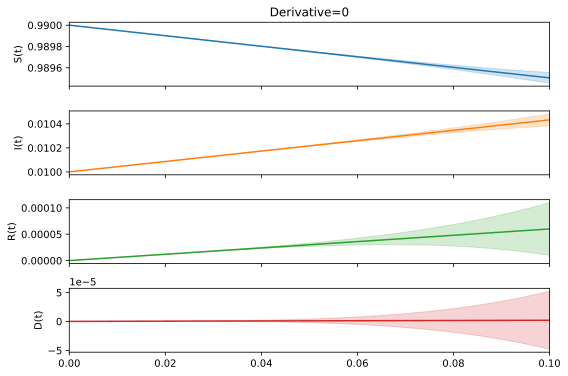

In [51]:
# TODO

_m, _C = condition_gaussian(m,C,E1,0,0,f(y0,tspan[0],p))
ms, Cs = compute_marginals(_m,_C,ts,A,Q)

fig, ax = plot_marginals(ts, ms, Cs) # adjust variable names as necessary

<div class="alert alert-block alert-success">
    <b>Check:</b> The mean should now no be constant anymore, but linear!
</div>

The last missing piece is to condition _on the ODE itself_. 
And to be able to do that, we need to condition on non-linear observations.

### Approximate conditioning via linearization <a class="anchor" id="linearization"></a>

Let $x$ be a Gaussian-distributed random variable with
$p(x) = \mathcal{N}(x; m^-, C^-)$,
and let $y$ be conditionally Gaussian-distributed given $x$, with
$p(y \mid x) = \mathcal{N}(y; h(x), R)$.
*Then, $x$ is **not** conditionally Gaussian-distributed given $y$.*
But to still have efficient, albeit approximate, inference, we can linearize the non-linear observation model $h(x)$ and then still do Gaussian inference.

*Taylor-approximation:* We linearize the model by doing a Taylor approximation:
$$
h(x) \approx h(\xi) + H(\xi)^\top (x - \xi),
$$
where $\xi$ is some linearization point $\xi$ and $H(\xi)$ is the Jacobian of $h$ at $\xi$.

Then, given the approximate observation model $p(y \mid x) \approx \mathcal{N}(y; h(\xi) + H(\xi)^\top (x - \xi), R)$, $x$ is again conditionally Gaussian-distributed given $y$, with the same update formula as above.

Typically we choose $\xi = m^-$, the mean of the prior.

<font color='gray'><i>FilteringFunFact: Doing Gaussian conditioning with a linearized observation model, where the linearization point corresponds to the prior mean, corresponds to an "extended Kalman update" step.</i></font> 

<div class="alert alert-block alert-info">
    <b>Task:</b> Implement the <code>linearize</code> function, which takes in a function <code>h</code> and a linearization point <code>xi</code>, and returns the parameters of a function $h_\xi(x) = A x + b$ that approximates $h(x)$ around $\xi$.
</div>

<font color='gray'><i>Hint:</i>
Use [`jax.jacfwd`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jacfwd.html) (or `jax.jacobian`, it doesn't really matter for this tutorial).
</font>

In [52]:
def linearize(
    h: Callable[[np.ndarray], np.ndarray], 
    xi: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    
    # TODO
    A = jax.jacfwd(h)(xi)
    b = h(xi) - A @ xi

    return A, b

Try it out:

In [53]:
h = lambda x: (x+1) ** 2
xi = np.array([0.0])
H, b = linearize(h, xi)
H, b

(Array([[2.]], dtype=float32), Array([1.], dtype=float32))

We can also visualize what's we're doing here:

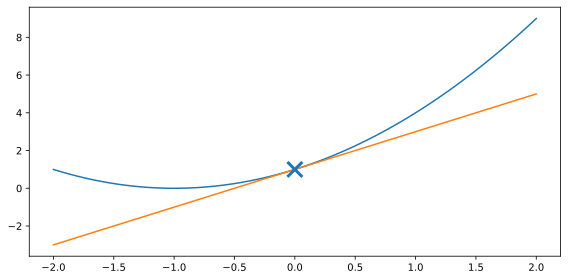

In [54]:
xs = np.linspace(-2, 2, 100)
fig, ax = plt.subplots()
ax.plot(xs, h(xs), label="h(x)")
ax.plot(xs, (H @ xs[None, :] + b).reshape(-1), label="h_lin(x)")
ax.plot(xi, h(xi), color="C0", marker="x", zorder=10, markersize=15, markeredgewidth=3)

Let's now perform approximate conditioning on a non-linear observation!

<div class="alert alert-block alert-info">

**Task:** 
Assume $x \sim \mathcal{N}(0, 1)$, a conditional $y \mid x \sim \mathcal{N} (y; h(x), 1e-3)$, and data $y = 0$.
Compute an approximate $p(x \mid y) \approx \mathcal{N} (m, P)$, by conditioning on the linearized (or actually "affine-ized"?) observation model and data.

</div>

In [58]:
m_before, C_before = np.zeros(1), np.eye(1)

# TODO
_A, _b = linearize(h, m_before)
m_conditioned, C_conditioned = condition_gaussian(m_before, C_before, _A, _b, 1e-3, 0)


m_conditioned, C_conditioned

(Array([-0.49987504], dtype=float32), Array([[0.00024992]], dtype=float32))

In [59]:
# to check that you updated in the correct direction:
assert h(m_conditioned) < h(m_before)

## 2.4. The ODE information operator <a class="anchor" id="information-operator"></a>

Let's get back to ODEs! 
From the lectures you probably already know how to construct the _information operator_, but let's briefly recall it nevertheless:
We have
$$\dot{y}(t) = f(y(t), t).$$
In the language of the chosen two-times integrated Wiener process prior, this is equivalent to
$$E_1 Y(t) = f( E_0 Y(t), t),$$
or equivalently
$$ 0 = E_1 Y(t) - f( E_0 Y(t), t).$$
**This is essentially a nonlinear observation model!** Indeed, let $h_i(Y(t_i)) := E_0 Y(t_i) - f(Y(t_i), t_i)$, then $h_i$ is a nonlinear function of the state $Y(t_i)$, and $h_i(Y(t_i)) = 0$ is the observation $i$.

<div class="alert alert-block alert-info">
    <b>Task:</b> 
    Implement the ODE information operator <code>h</code> at time $t_0$.
</div>

*Note:* The vector-field $f$ is independent of the time $t$; at this point the dependence on $t$ is just there to make the code more general.

In [60]:
def h(y):
    return E1 @ Y - f (E0 @ Y,tspan[0], p)

With `h` defined we should be able to just condition (approximately) on this nonlinear observation model.
So, let's "condition on the ODE"!


<div class="alert alert-block alert-info">

**Task:** Condition the initial distribution `m0, C0` on the ODE information operator `h` at time `t0`.
    
</div>

In [ ]:
# TODO: Compute `m0_conditioned`, `C0_conditioned`
_A, _b = linearize(m0,h)
m0_conditioned, C0_conditioned = condition_gaussian

print(m0_conditioned)

...this is still zero mean?? Did anything go wrong? 
No! That's because the zero function $y(t) = 0$ actually solves the ODE, too.
That is, $f(0, t) = 0$ holds. 
Therefore the mean did not change - it was already good.

If we condition on the initial value first, and then on the ODE, we get a different result:

<div class="alert alert-block alert-info">

**Task:** Condition the initial distribution `m0, C0` on the initial value `y0`, and then on the ODE information operator `h` at time `t0`.
    
</div>

In [ ]:
# TODO
print(f"Prior: y(t0)={E0@m0}, y'(t0)={E1@m0}")

m0_conditioned_0, C0_conditioned_0 = 
print(f"After conditioning on the initial value: y(t0)={E0@m0_conditioned_0}, y'(t0)={E1@m0_conditioned_0}")

m0_conditioned_1, C0_conditioned_1 = 
print(f"After conditioning on the ODE: y(t0)={E0@m0_conditioned_1}, y'(t0)={E1@m0_conditioned_1}")

<div class="alert alert-block alert-success">
    
**Check:** 
After conditioning on the initial value `y(t0)` should show the correct value, but `y'(t0)` should be zero; 
after also conditioning on the ODE, `y(t0)` should be the same as before, but `y'(t0)` should be non-zero (in the orders of 1e-5 to 1e-3).
    
</div>

At this point we have all the building blocks to implement the full ODE filtering algorithm:
- we have a 2-times integrated Wiener process prior
- we know how to _predict_ future values under the prior (via Gaussian marginalization)
- we know how to _update_ the distribution, both on linear observations (for the initial value) and (approximately) on non-linear observations (for the ODE)

**Let's put it all together!**

<a class="anchor" id="ode-filtering"></a>
# 3. The ODE Filter

We use everything that we did above and put it together, to build the following algorithm:

<div class="alert alert-block alert-warning">
    
**Algorithm**

    Input:
    - an initial value problem, consisting of 
      * a vector-field f and 
      * initial value y0,
    - a prior, consisting of 
      * an initial distribution (m0, C0), 
      * transition matrices A(h), Q(h), and 
      * projections to the zeroth and first derivative E0, E1,
    - a discrete-time grid ts=${t_i}_{i=1}^N$ chosen by the user, typically as $t_k=t_0+k*dt$ for some time step dt>0.
  
    Then:
    1. Condition the prior on the initial value y0; Condition the prior on the initial derivative $y'(t_0) = f(y0, t_0)$;
    2. For each time point $t_i$, $i \in \{1, \dots, N\}$:
       - Extrapolate from $p(Y(t_{i-1})) = N(m_{i-1}, C_{i-1})$ to $p(Y(t_i)) = N(m_i^P, C_i^P)$ using the prior, via Gaussian marginalization
       - Condition $Y(t_i)$ on the ODE information operator $h_i$ at time $t_i$, by
          1. linearizing the ODE information operator around the prior mean
          2. conditioning on the linearized ODE information operator
    
    Return: the computed marginals $p(Y(t_i)) \sim \mathbb{N} (m_i, C_i)$, $i \in \{1, \dots, N\}$.
    
</div>
    
    
<div class="alert alert-block alert-info">
    
**Task:** Implement the algorithm described above in the `ode_filter` function.
    
</div>

In [ ]:
def ode_filter(
        f: Callable[[np.ndarray, float], np.ndarray],
        y0: np.ndarray,
        ts: np.ndarray,
        m0: np.ndarray,
        C0: np.ndarray,
        A: Callable[[float], np.ndarray],
        Q: Callable[[float], np.ndarray],
        E0: np.ndarray,
        E1: np.ndarray,
        p=p, # will become relevant later, so do pass it to `f`!
    ) -> Tuple[np.ndarray, np.ndarray]:

    # Output:
    ms = np.zeros((len(ts), d * (q + 1)))
    Cs = np.zeros( (len(ts), d * (q + 1), d * (q + 1)))
    
    # TO IMPLEMENT

    return ms, Cs

Let's test it:

In [ ]:
dt = 1
ts = np.linspace(tspan[0], tspan[1], int((tspan[1] - tspan[0]) / dt))
ms, Cs = ode_filter(f, y0, ts, m0, C0, A, Q, E0, E1)

# The filter returns marginals, so we plot them with `plot_marginals`
fig, axes = plot_marginals(ts, ms, Cs)
for j in range(d):
    axes[j].plot(times, ys[:, j], color="black", linestyle="--")
[ax.set_ylim(-0.1, 1.1) for ax in axes]

<div class="alert alert-block alert-success">
    
**Check:** 
The ODE filter posterior mean (colored lines) and the reference solution (black dashed lines) should (visually) coincide,
and there should be a visible credible interval around it.
    
</div>

Looks great! The `ode_filter` is able to solve the ODE, and it also returns uncertainties!

Let's visualize uncertainties a bit more by looking at the space of errors directly, i.e. $y(t) - \hat{y}(t)$:

In [ ]:
def plot_pn_errors(ts, ms, Cs, ys_acc):
    print(f"Make sure that this here is an integer: {dt / dt_small}")
    stride = int(dt / dt_small)
    errors = ys_acc[::stride] - ms@E0.T

    fig, axes = plt.subplots(d, figsize=(FIGSIZE[0], FIGSIZE[1]/3*d), sharex=True)
    for j in range(d):
        axes[j].plot(ts, np.zeros_like(errors[:, j]), color=f"C{j}")
        axes[j].fill_between(
            ts,
            - 3 * np.sqrt(Cs[:, j, j]),
            3 * np.sqrt(Cs[:, j, j]),
            color=f"C{j}",
            alpha=0.2,
        )
        axes[j].plot(ts, errors[:, j], color="black", linestyle="--")
        axes[j].set_ylabel(labels[j])
        axes[j].set_xlim(ts[0], ts[-1])
    return fig, axes

fig, axes = plot_pn_errors(ts, ms, Cs, ys)

<div class="alert alert-block alert-success">
    
**Check:** 
The colored and black-dashed lines should both be around zero, and the y-axis should be in the order of 1.
    
</div>

This plot reveals an important issue:
*The actual error seems to be much smaller than the posterior uncertainty.*
To be a meaningful error estimate, the posterior uncertainty should be *calibrated*, which (among other things also) means that it should have a similar scale as the true error.
How do we do this? By estimating the hyperparameter `sigma_sq` that we didn't really talk about yet!

# 4. Calibrating uncertainties <a class="anchor" id="calibration"></a>

*There is a hyperparameter $\sigma^2$ in our choice of 2-times integrated Wiener process prior that we (purposefully) didn't talk about yet.*

As our prior, we have
$$\begin{aligned}
Y(t_0) &\sim \mathcal{N}(0, \sigma^2 I), \\
Y(t+h) \mid Y(t) &\sim \mathcal{N}(Y(t); A(h) Y(t), \sigma^2 Q(h)),
\end{aligned}$$
with some scalar hyperparameter $\sigma^2$, often also called the *diffusion* parameter.

So basically, all the covariances that appear in the prior are scaled by some a-priori unknown parameter $\sigma^2$.  
*It is not really surprising that the posterior uncertainty is not calibrated, if there is some (so far) arbitrarily chosen hyperparameter floating around in our model!*

## How to estimate the diffusion $\sigma^2$ 

We can estimate the diffusion $\sigma^2$ by maximizing the likelihood of the observations, 
where, strictly speaking, "observations" here means the ODE information "$0$" observed with the obseravtion model "$h_i$". 
We will not go into detail _why_ this is the correct thing to do 
(for that have a look [[4]](#r1) or [[7]](#r2)),
but **this is how it works:**
$$
\hat{\sigma}_\text{MLE}^2 = \frac{1}{Nd} \sum_{i=1}^N (H m_i^P + b)^\top (H C_i^P H^\top)^{-1} (H m_i^P + b),
$$
are the mean and covariance of the distribution _before_ the conditioning at time $t_i$ (in filtering called the "prediction" mean and covariance, thus the "P").
Note that the quantities inside the sum are computed during the Gaussian conditioning anyways, so a good place to compute these terms is inside the Gaussian conditioning function `condition_gaussian`.
Then, once we have $\hat{\sigma}_\text{MLE}^2$, just re-scale the covariances:
$$ C_i^\text{cal} =  \hat{\sigma}_\text{MLE}^2 \cdot C_i. $$
That's it!

<font color='gray'>
    
If you're interested in the details and the derivations and proofs to why we do this, 
have a look at Section 4 of [[4]](#r1) or Section 3 of [[2]](#r2).
    
</font>


<div class="alert alert-block alert-info">
    
**Task**: Implement a new function `condition_gaussian_cal` that computes not just the conditioned mean and covariance, but also the term inside the sum above.
    
</div>

In [ ]:
def condition_gaussian_cal(
    m: np.ndarray, 
    P: np.ndarray, 
    A: np.ndarray, 
    b: np.ndarray, 
    C: np.ndarray, 
    y: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
   
    # TO IMPLEMENT

    return mnew, Pnew, sigma_sq_increment

Let's implement a _calibrated_ ODE filter now!

<div class="alert alert-block alert-info">
    
**Task:** Implement the calibrated ODE filter in the `ode_filter_cal` function.
    
</div>

In [ ]:
def ode_filter_cal(
        f: Callable[[np.ndarray, float], np.ndarray],
        y0: np.ndarray,
        ts: np.ndarray,
        m0: np.ndarray,
        C0: np.ndarray,
        A: Callable[[float], np.ndarray],
        Q: Callable[[float], np.ndarray],
        E0: np.ndarray,
        E1: np.ndarray,
        p=p,
) -> Tuple[np.ndarray, np.ndarray]:
    
    # Output:
    ms = np.zeros((len(ts), d * (q + 1)))
    Cs = np.zeros( (len(ts), d * (q + 1), d * (q + 1)))
    
    # TO IMPLEMENT

    return ms, Cs


Let's test it:

In [ ]:
dt = 1
ts = np.linspace(tspan[0], tspan[1], int((tspan[1] - tspan[0]) / dt))
ms, Cs = ode_filter_cal(f, y0, ts, m0, C0, A, Q, E0, E1)

# The filter returns marginals, so we plot them with `plot_marginals`
fig, axes = plot_marginals(ts, ms, Cs)
for j in range(d):
    axes[j].plot(times, ys[:, j], color="black", linestyle="--")
[ax.set_ylim(-0.1, 1.1) for ax in axes]

In [ ]:
dt = 1
ts = np.linspace(tspan[0], tspan[1], int((tspan[1] - tspan[0]) / dt))
ms, Cs = ode_filter_cal(f, y0, ts, m0, C0, A, Q, E0, E1)
fig, axes = plot_pn_errors(ts, ms, Cs, ys)

<div class="alert alert-block alert-success">
    
**Check:** 
The colored lines should be exactly zero, but this time both the colored uncertainty estimates and the numerical error (the black lines) should be visibly non-zero.
    
</div>

**It works! We again get relatively small errors, but this time the errors live on the same scale as the error estimate!**

# 5. Parameter estimation with ODE filters <a class="anchor" id="parameter-inference"></a>

<font color='gray'>

*At this point we're done with the main part: We implemented an ODE filter, completely from scratch. Nice!*  
*This final section shows how to _use_ the ODE filter in a problem setting that is not purely about _simulating_ and ODE, but about _learning_ the ODE from data.*

</font>

In many problems of interest we don't actually want to solve a known ODE.
Instead, we have some observed data and a hypothesis for how the data was generated, i.e. a model, and we want to learn the parameters of the model that fit the data best.
We call this _parameter estimation_, or sometimes also an _inverse problem_.

In the case of ODEs, we can formulate the parameter estimation problem as follows:
- We have an **initial value problem**
  $$\dot{y}(t) = f(y(t), t, \theta), \quad t \in [t_0, t_\text{max}], \qquad y(t_0) = y_0(\theta),$$
  where $\theta$ is a vector of (unknown) parameters.
- We have **observations**
  $$u_i = H y(t_i) + \epsilon_i, \qquad i \in \{1, \dots, M\},$$
  where $H$ is a linear observation operator, $\epsilon_i \sim \mathcal{N} (0, \nu^2I)$ is iid. Gaussian noise, and $t_i$ are the observation times.
- **We want to estimate the parameters $\theta$:** For this tutorial we will just compute _maximum-likelihood estimates_
  $$\hat{\theta} = \arg\max_\theta \mathcal{L}(\theta) = \arg\max_\theta \log p(u_1, \dots, u_N \mid \theta).$$
  <font color='gray'>
  The method can also be extended to maximum a-posteriori estimates or to full Bayesian inference; in those cases just add a prior and then either optimize or run MCMC, or other (possibly approximate) inference methods. 
  But in both cases you need to compute the marginal likelihood - this is the main content of this section.
  </font>

How do we do this in the context of ODE filters? [This paper [10]](#r7) explains how! 
In a nutshell, we use the ODE filter _posterior_ as a _prior_ for a standard Gaussian process regression problem, and then compute the maximum likelihood estimate of the parameters $\theta$ by optimizing the log-likelihood.
This is what we'll do - in a slightly simplified setting.

## The concrete parameter inference problem 

We still consider the SIRD model as [above](#sird), but with a reduced time-span $t \in [0, 15]$.  
Let $\beta = 0.5$, $\gamma = 0.06$, $\eta = 0.002$ (as above) be the unknown ground truth parameters.  
As _data_, we have just a single observation $u = H y(t_\text{max})$ at the final time point, 
with $H = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$, that is, we observe only the last two dimensions of $y$ corresponding to the number of recovered and dead individuals.
Our goal is then to estimate the parameters $\theta = (\beta, \gamma, \eta)$ from this single observation.

So on a high level, the question is: *What are the contact rate, the recovery rate, and the death rate, that would explain the observed number of recovered and dead individuals?*

Visually, the problem looks like this:

In [ ]:
p_true = (0.5, 0.06, 0.002)

_tspan = (0, 15)
_ts = np.linspace(*_tspan, 20)
ms, Cs = ode_filter_cal(f, y0, _ts, m0, C0, A, Q, E0, E1, p=p_true) # where we expliclty pass the true parameters

H = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])
data = H@E0@ms[-1]

fig, axes = plt.subplots(d, figsize=(FIGSIZE[0], FIGSIZE[1]/3*d), sharex=True)
for i in range(d):
    axes[i].plot(_ts, ms[:, i], color="black", linestyle="--")
    if i >= len(data):
        axes[i].plot(_ts[-1], data[i-len(data)], marker="x", color=f"C{i}", markersize=15, markeredgewidth=3, label=f"data")
        axes[i].legend(loc="upper left")
    axes[i].set_ylabel(labels[i])

Our goal is to recover the true solution (the black dashed line) from the observation (the colored cross).

To do this via maximum-likelihood estimation, we need two things:
1. We need a marginal likelihood function $p(u \mid \theta)$, and then
2. We maximize this marginal likelihood (or actually minimize the negative marginal log-likelihood) with some optimizer.
So let's get to it!

## The marginal likelihood
When we run an ODE filter, we compute a posterior
$$p(y(t_i) \mid \theta) = \mathcal{N} \left( y(t_i); E_0 m_i, E_0 P_i E_0^\top \right), \qquad i \in \{1, \dots, N\}.$$
In the parameter inference problem, we assume a data likelihood
$$p(u \mid y(t_\text{max})) = \mathcal{N}(u; H y(t_\text{max}), \sigma^2 I).$$
So, using the (approximate) posterior from the ODE filter above, we can compute the (approximate) marginal likelihood:
$$
p(u \mid \theta) 
= \int p(u \mid y(t_\text{max})) p(y(t_\text{max}) \mid \theta) \mathrm{d}y(t_\text{max}) 
= \mathcal{N} \left(u; H E_0 m_N, H E_0 P_N E_0^\top H^\top + \sigma^2 I \right),
$$
since both distributions are Gaussian.  

**That's it! This is the one formula that we need to implement to compute the marginal likelihood and then do parameter inference with ODE filters.**

<div class="alert alert-block alert-info">
    
**Task**: Implement a negative marginal log-likelihood function `nll` that computes the negative log-likelihood of the observation $u$ given the parameters $\theta$.
    
</div>

<font color='gray'><i>Hint:</i>
Don't forget to project the ODE filter posterior to the solution space with `E0`, and the solution to the data space with `H`.
</font>

<font color='gray'><i>Hint 2:</i>
You can use `scipy.stats.multivariate_normal.logpdf` class to compute the log-likelihood of a multivariate Gaussian.
</font>


In [ ]:
def nll(p) -> float:
    
    # TO IMPLEMENT

    return negloglik

p0 = np.array((0.3, 0.03, 0.003))
nll(p_true), nll(p0)

<div class="alert alert-block alert-success">
    
**Check:** `nll(p_true)` should be a lower value than `nll(p0)`. Since `p_true` was used to generate the data, its likelihood should be much higher than the likelihood of another arbitrarily chosen parameter!
    
If both values are the same, you probably did not pass the parameter `p` on to the ODE vector field `f` in your `ode_filter_cal` implementation.

</div>

## Minimizing the negative log-likelihood

There is only one thing left to do: Compute the maximum-likelihood estimate by minimizing `nll`!

<div class="alert alert-block alert-info">
    
**Task**: Starting from `p0`, minimize the negative marginal log-likelihood `nll` with [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).
    
</div>

<font color='gray'><i>Hint:</i>
The "Nelder-Mead" method should work reasonably well. Adding bounds (e.g. `bounds=[(0.1, 1.0), (0.01, 0.1), (0.001, 0.01)]`) might help with stability.

(also this might take quite a few minutes, ~5min on my computer)
</font>



In [ ]:
# TODO: optimize the loss (takes a while)


p_opt, nll(p_opt)

<div class="alert alert-block alert-success">
    
**Check:** `nll(p_opt)` should be much lower than `nll(p0)`, otherwise the optimization went completely wrong.
    
Also: It is quite probable you did not actually recover the true parameters - _this is intended_. We will have a look at the result of the optimization next.
    
</div>

To properly evaluate the quality of the result, let's make another plot:

In [ ]:
ms0, Cs0 = ode_filter_cal(f, y0, _ts, m0, C0, A, Q, E0, E1, p=p0)
ms_opt, Cs_opt = ode_filter_cal(f, y0, _ts, m0, C0, A, Q, E0, E1, p=res.x)

fig, axes = plt.subplots(d, figsize=(FIGSIZE[0], FIGSIZE[1]/3*d), sharex=True)
for i in range(d):
    axes[i].plot(_ts, ms[:, i], color="black", linestyle="--", label="p_true")
    axes[i].plot(_ts, ms0[:, i], color=f"C{i}", linestyle="--", label="p0")
    axes[i].plot(_ts, ms_opt[:, i], color=f"C{i}", label="p_opt")
    if i >= len(data):
        axes[i].plot(_ts[-1], data[i-len(data)], marker="x", color=f"C{i}", markersize=15, markeredgewidth=3, label=f"data")
    axes[i].legend(loc="upper left")
    axes[i].set_ylabel(labels[i])

It worked! At least, kind of? We did recover parameters that explain the data well. 
But, the inferred parameters are actually quite different from the true parameters and we see a mismatch between the true and the inferred solution, in particular for the number of susceptible and infected individuals.
That's because the very limited data we have is not actually sufficient to identify the parameters uniquely - 
_which is why it would indeed make sense to be more Bayesian about this and compute an actual posterior over the parameters_. 
So if you have some time left, you might want to try that out!

<font color='gray'>
Also: If we had a different setup where S and I are observed too, the inferred solution would have been very close to the true solution (you can verify this for yourself by changing `H` above!).
</font>



**This concludes the tutorial!** Thanks a lot for reading and coding, and for participating in the workshop, I hope you enjoyed it!

# Things that we had to leave out <a class="anchor" id="more"></a>

We built a functioning ODE filter from scratch, but there are a few things that we had to leave out for the sake of simplicity.
The actual algorithms that appear in most of the literature are a bit more involved, and there are many bells and whistles that can be added to make these methods more flexible, more robust and more performant, _which matter a lot when you actually want to use these methods in practice_.
Things we didn't cover include:

- **Smoothing:**   
  The algorithm we implemented above is a _filter_. 
  The "posterior" we computed is essentially
  $$ p \left( y(t_i) \mid y(0) = y_0, \{ y'(t_i) = f(y(t_i), t_i) \}_{j=1}^{i-1} \right), \qquad i \in \{1, \dots, N\}, $$
  that is, the posterior of the solution at time $t_i$ only considers the ODE information up to time $t_{i-1}$.
  But what we actually described [above](#pn) is a posterior that considers the ODE information _everywhere_.
  This is what a _smoother_ does.
  Typically, if you are looking at solution strategies, this might be the quantity you are interested in; and if you want _interpolation_ (i.e. computing the solution at arbitrary times), you will also need to smooth.  
  To learn more about filtering and smoothing in general have a look at [this book](#r3) [[1]](#r3);
  and in the ODE context, the ["Probabilistic Numerics" Book](#r0) is a great starting point!
- **Other priors:**   
  In this tutorial we only considered a two-times integrated Wiener process prior, but depending on your problem you might want higher orders.
  Generally speaking, $q$-times integrated Wiener processes are the most popular choice, and all the [software](#software) packages linked below implement them;
  but you could also use other Gauss--Markov priors, e.g. $q$-times integrated Ornstein--Uhlenbeck processes, or even more general Markov processes.  
  [This paper [5]](#r4) mentions the various priors; or check out the [ProbNumDiffEq.jl documentation](https://docs.sciml.ai/ProbNumDiffEq/stable/priors/) to just use them.
- **Square-root implementation & preconditioning**  
  It turns out that the standard extended Kalman filtering implementation that we did here can become numerically unstable for high-dimensional problems and/or very small step sizes [[6]](#r5) - _this is a problem that you will actually run into in practice!_
  The solution is to use a square-root implementation, together with preconditioning (essentially a change of coordinates in the state space).  
  All the software packages linked [below](#software) implement this and provide numerically stable solvers.
- **Approximate linearization:**  
  The ODE filter we implemented is essentially a _extended Kalman filter_, which is a Gaussian filter combined with a first-order Taylor linearization of the vector field.
  There is more you can do:
  We can do a zeroth-order Taylor linearization of the vector field to gain some speed (actually a lot of speed; but at the cost of stability and coarser uncertainty quantification) [[9]](#r6);
  or we could also do _statistical linearization_ (related to the _unscented_ Kalman filter that you might have heard about) [[2]](#r9) or [[4]](#r1).  
  If you want to just use this functionality, have a look at [probdiffeq](https://pnkraemer.github.io/probdiffeq/) which provides a range of linearization strategies, implemented very efficiently.
- **Adaptive time-stepping:**  
  In practice, we often want to discretize the ODE _adaptively_, to have more steps in regions where the solution is changing rapidly, and fewer steps in regions where the extrapolation is very accurate.
  To learn how to do this with ODE filters, have a look at [[3]](#r10) or [[7]](#r2).  
  Or again: Just use any one of the [software](#software) packages linked below.
- **Better initialization with taylor-mode autodiff:**  
  Above, we initialized the ODE filter with the solution and derivative at the first time point - which left the second derivative, _which we do also model_, uncertain.
  [This is not ideal [6], but we can do better:](#r5)
  The ODE actually contains information about _all_ derivatives of the solution (just apply the chain rule to verify this),
  and it turns out that we can efficiently compute these with a computer by using Taylor-mode automatic differentiation!
  For more information have a look at [[6]](#r5), 
  or [the documentation of `jax.experimental.jet`](https://jax.readthedocs.io/en/latest/jax.experimental.jet.html),
  or at [TaylorIntegration.jl](https://perezhz.github.io/TaylorIntegration.jl/stable/).  
  Or, just use it with any of the [software](#software) packages linked below.
- **Flexible information operators:**  
  There are many ODE-related problems that do not 100% exactly correspond to the problem setup from [above](#problem-setup), for example higher-order ODEs, dynamical systems with conserved quantities (e.g. often energy, mass, or momentum), or even differential-algebraic equations.
  _You can solve these with (O)DE filters too!_ 
  See [this paper [8]](#r8) for an explanation of how to do this; 
  and again, just use any of the [software](#software) packages linked below to do this in practice.

# Software packages <a class="anchor" id="software"></a>

### [ProbNumDiffEq.jl](https://nathanaelbosch.github.io/ProbNumDiffEq.jl/stable/): *Probabilistic Numerical Differential Equation solvers in Julia*

ProbNumDiffEq.jl provides probabilistic numerical ODE solvers to the Julia [DifferentialEquations.jl](https://diffeq.sciml.ai) ecosystem.
They are implemented as easy-to-use drop-in replacements to their classic counterparts, aim to be as fast as possible, and provide most of the bells and whistles mentioned [above](#more).
Have a look at the [documentation](https://nathanaelbosch.github.io/ProbNumDiffEq.jl/stable/) for more information; or just try them out with the following code snippet:

<div class="alert alert-block alert-info">

**Example:** Solving the SIRD model as defined in this tutorial with ProbNumDiffEq.jl

```julia
using ProbNumDiffEq, Plots

# Define the ODE problem
function f(u, p, t)
    S, I, R, D = u
    β, γ, μ = p
    return [ -β * S * I, β * S * I - γ * I - μ * I, γ * I, μ * I ]
end 
u0 = [0.99, 0.01, 0.0, 0.0]
tspan = (0.0, 100.0)
p = [0.5, 0.06, 0.002]
prob = ODEProblem(f, u0, tspan, p)

# Solve the ODE problem with an ODE filter
sol = solve(prob, EK1())

# Plot the solution
plot(sol)
```

</div>

### [probdiffeq](https://pnkraemer.github.io/probdiffeq/): *Probabilistic solvers for differential equations in Jax*

ProbDiffEq implements adaptive probabilistic numerical solvers for initial value problems.
It inherits automatic differentiation, vectorisation, and GPU capability from JAX, works well with JAX's just-in-time compilation to achieve high performance, and is compatible with other packages from the Jax ecosystem such as [Optax](https://optax.readthedocs.io/en/latest/index.html) or [Blackjax](https://blackjax.readthedocs.io/en/latest/).
Have a look at it's documentation [here](https://pnkraemer.github.io/probdiffeq/)!

<div class="alert alert-block alert-info">

**Example:** Solving the SIRD model as defined in this tutorial with `probdiffeq`

```python
import jax
import jax.numpy as jnp

from probdiffeq import solution_routines, solvers
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

# Define the ODE problem 
@jax.jit
def vector_field(y, *, t, p):
    S, I, R, D = y
    β, γ, μ = p
    return jnp.array([ -β * S * I, β * S * I - γ * I - μ * I, γ * I, μ * I ])
u0 = jnp.asarray([0.99, 0.01, 0.0, 0.0])
t0, t1 = 0.0, 100.0
p = jnp.asarray([0.5, 0.06, 0.002])

# Solve the ODE problem with an ODE filter
implementation = recipes.DenseTS1.from_params(ode_shape=(len(u0),))
strategy = smoothers.Smoother(implementation)
solver = solvers.MLESolver(strategy)
solution = solution_routines.solve_with_python_while_loop(
    vector_field, initial_values=(u0,), t0=t0, t1=t1, solver=solver, parameters=p
)

# Look at the solution
print("u =", solution.u)
```

</div>

### [probnum](https://probnum.readthedocs.io/en/latest/index.html): *Probabilistic Numerics in Python*

ProbNum is a Python toolkit which provides probabilistic numerical methods not only for ODEs, but for a whole range of numerical problems in linear algebra, optimization, quadrature and differential equations.
It also contains quite a large range of methods for Bayesian filtering and smoothing that you can use to build your own probabilistic ODE solvers.
To learn more, have a look at its excellent documentation and the many tutorials [here](https://probnum.readthedocs.io/en/latest/index.html).

<div class="alert alert-block alert-info">

**Example:** Solving the SIRD model as defined in this tutorial with `probnum`

```python
import numpy as np
from probnum.diffeq import probsolve_ivp

# Define the ODE problem
p = [0.5, 0.06, 0.002]
def f(t, y):
    S, I, R, D = y
    β, γ, μ = p
    return np.array([ -β * S * I, β * S * I - γ * I - μ * I, γ * I, μ * I ])
def Jf(t, y): # define the jacobian manually
    S, I, R, D = y
    β, γ, μ = p
    return np.array([
        [-β * I, -β * S, 0, 0],
        [β * I, β * S - γ - μ, -γ, -μ],
        [0, γ, 0, 0],
        [0, μ, 0, 0]
    ])
y0 = np.array([0.99, 0.01, 0.0, 0.0])
t0, tmax = 0.0, 100.0

# Solve the ODE problem with an ODE filter
sol = probsolve_ivp(f, t0, tmax, y0, df=Jf, method="ek1")

# Look at the solution
print("mean: ", sol.states.mean)
```

# References <a class="anchor" id="references"></a>

(sorted roughly by date)

- <a class="anchor" id="r3">[1]</a> *Bayesian Filtering and Smoothing*, Särkkä, 2013 ([link](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67))
- <a class="anchor" id="r9">[2]</a> *Active Uncertainty Calibration in Bayesian ODE Solvers*, Kersting and Hennig, 2016 ([link](http://auai.org/uai2016/proceedings/papers/163.pdf))
- <a class="anchor" id="r10">[3]</a> *A probabilistic model for the numerical solution of initial value problems*, Tiemann (né Schober) et al, 2019 ([link](https://link.springer.com/article/10.1007/s11222-017-9798-7))
- <a class="anchor" id="r1">[4]</a> *Probabilistic solutions to ordinary differential equations as nonlinear Bayesian filtering: a new perspective*, Tronarp et al, 2019 ([link](https://link.springer.com/article/10.1007/s11222-019-09900-1))
- <a class="anchor" id="r4">[5]</a> *Bayesian ODE solvers: the maximum a posteriori estimate*, Tronarp et al, 2021 ([link](https://link.springer.com/article/10.1007/s11222-021-09993-7))
- <a class="anchor" id="r5">[6]</a> *Stable Implementation of Probabilistic ODE Solvers*, Krämer and Hennig, 2020 ([link](https://arxiv.org/abs/2012.10106))
- <a class="anchor" id="r2">[7]</a> *Calibrated Adaptive Probabilistic ODE Solvers*, Bosch et al, 2021 ([link](http://proceedings.mlr.press/v130/bosch21a.html))
- <a class="anchor" id="r8">[8]</a> *Pick-and-Mix Information Operators for Probabilistic ODE Solvers*, Bosch et al, 2022 ([link](https://proceedings.mlr.press/v151/bosch22a.html))
- <a class="anchor" id="r6">[9]</a> *Probabilistic ODE Solutions in Millions of Dimensions*, Krämer et al, 2022 ([link](https://proceedings.mlr.press/v162/kramer22b.html))
- <a class="anchor" id="r7">[10]</a> *Fenrir: Physics-Enhanced Regression for Initial Value Problems*, Tronarp et al, 2022 ([link](https://proceedings.mlr.press/v162/tronarp22a.html))

Or you can also find a lot of information covering (most of) the topics above in the PN textbook:

- <a class="anchor" id="r0"></a> *Probabilistic Numerics*, Hennig et al, 2021 ([link](https://www.probabilistic-numerics.org/textbooks/))